In [4]:
import os
import glob
import time
import numpy as np
import seaborn as sns
from string import punctuation
from tqdm.notebook import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
BASE_PATH = "../datasets/large_data/"
FILE_RE   = "*.txt"
OUT_PATH  = "results.csv"

# Global variables
SW = stopwords.words("english") # Common english stop-words
ps = PorterStemmer()

In [3]:
# Preprocessing:
def preprocess(F):
    F = F.lower() 
    F.translate(str.maketrans('', '', punctuation))
    F = word_tokenize(F)
    F = [ps.stem(f) for f in F if f.isalnum() and f not in SW]
    return F

In [52]:
# Process files
preprocessed_files = []
unpreprocessed_files = []

for filepath in glob.glob(os.path.join(BASE_PATH, FILE_RE)):
    with open(filepath, 'r', encoding="utf-8", errors="ignore") as f:
        F = f.read()
        unpreprocessed_files.append(F)
        preprocessed_files.append(preprocess(F))

N_DOCS = len(preprocessed_files)

tagged_data = [
    TaggedDocument(words=file, tags=[i]) 
    for i, file in enumerate(preprocessed_files)
]

In [71]:
# Doc2Vec Model: documentation: https://radimrehurek.com/gensim/models/doc2vec.html

## Hyper-parameters:
embedding_dimension = 100
# lr = 0.025 # Initial learning rate
min_count = 10 # Ignore all words having frequency less than 10
N_EPOCHS = 100

## Initialize model:
model = Doc2Vec(
    dm = 0, # Use distributed BoW
    vector_size = embedding_dimension, 
    # alpha = lr, 
    min_count = min_count,
    epochs = N_EPOCHS
)

## Build vocab:
model.build_vocab(tagged_data)

In [72]:
# Train the model on our own data from scratch
model.train(
    tagged_data, 
    total_examples=model.corpus_count, 
    epochs=model.epochs
)

In [73]:
# Get the embeddings:
document_embeddings = np.zeros((N_DOCS, embedding_dimension))
for i in range(N_DOCS):
    document_embeddings[i] = model.docvecs[i]

# Normalize the embeddings:
document_embeddings = document_embeddings/np.reshape(np.linalg.norm(document_embeddings, axis=1), (N_DOCS, 1))

# Cosine similarity matrix:
csm = document_embeddings@document_embeddings.T

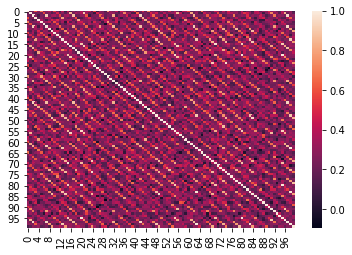

<Figure size 432x288 with 0 Axes>

In [74]:
# Dump results into a CSV file
np.savetxt("results/cosine_" + OUT_PATH, csm, fmt="%.4f", delimiter=',')

# Cosine Heatmap
chm = sns.heatmap(csm)
fig1 = chm.get_figure()
fig1.savefig("plots/cosine_heatmap.png", dpi=150)   
plt.figure()
plt.show()